In [1]:
from datasets import load_dataset

spx = load_dataset('misikoff/SPX', split='train')

spx = spx.to_polars().select(['Date', 'Open', 'High', 'Low', 'Close'])

print(spx)

shape: (24_167, 5)
┌────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ Date       ┆ Open        ┆ High        ┆ Low         ┆ Close       │
│ ---        ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│ str        ┆ f64         ┆ f64         ┆ f64         ┆ f64         │
╞════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ 1927-12-30 ┆ 17.66       ┆ 17.66       ┆ 17.66       ┆ 17.66       │
│ 1928-01-03 ┆ 17.76       ┆ 17.76       ┆ 17.76       ┆ 17.76       │
│ 1928-01-04 ┆ 17.719999   ┆ 17.719999   ┆ 17.719999   ┆ 17.719999   │
│ 1928-01-05 ┆ 17.549999   ┆ 17.549999   ┆ 17.549999   ┆ 17.549999   │
│ 1928-01-06 ┆ 17.66       ┆ 17.66       ┆ 17.66       ┆ 17.66       │
│ …          ┆ …           ┆ …           ┆ …           ┆ …           │
│ 2024-03-11 ┆ 5111.959961 ┆ 5124.660156 ┆ 5091.140137 ┆ 5117.939941 │
│ 2024-03-12 ┆ 5134.299805 ┆ 5179.870117 ┆ 5114.47998  ┆ 5175.27002  │
│ 2024-03-13 ┆ 5173.490234 ┆ 5179.140137 ┆ 5151.879883 ┆ 5

In [2]:
# ============================================
# STEP 1: PREPARE DATA
# ============================================

from sklearn.preprocessing import MinMaxScaler

# Extract Close prices
data = spx['Close'].to_numpy()

# Normalize data to [0, 1] range (LSTMs work better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()

print(f"\nOriginal Close prices (first 5): {data[:5]}")
print(f"Scaled Close prices (first 5): {data_scaled[:5]}")


Original Close prices (first 5): [17.66     17.76     17.719999 17.549999 17.66    ]
Scaled Close prices (first 5): [0.00256437 0.0025837  0.00257597 0.00254309 0.00256437]


In [3]:
# ============================================
# STEP 2: CREATE SEQUENCES
# ============================================
# Use past N days to predict next day's closing price

import numpy as np

def create_sequences(data, seq_length):
    """
    Convert time series into sequences
    Input: [17.66, 17.76, 17.72, 17.55, 17.66, ...]
    Output: 
        X: [[17.66, 17.76, 17.72, ...], [17.76, 17.72, 17.55, ...], ...]
        y: [next_day_close_1, next_day_close_2, ...]
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Use 60 days of data to predict next day
SEQ_LENGTH = 60

X, y = create_sequences(data_scaled, SEQ_LENGTH)

print(f"\nSequence shape:")
print(f"X shape: {X.shape}  # (samples, sequence_length)")
print(f"y shape: {y.shape}  # (samples,)")

# ============================================
# STEP 3: TRAIN/TEST SPLIT
# ============================================

import torch

train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
# LSTM expects input shape: (batch_size, seq_length, input_size)
X_train = torch.FloatTensor(X_train).unsqueeze(-1)  # Add feature dimension
X_test = torch.FloatTensor(X_test).unsqueeze(-1)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Sequence shape:
X shape: (24107, 60)  # (samples, sequence_length)
y shape: (24107,)  # (samples,)

Training data shape: torch.Size([19285, 60, 1])
Testing data shape: torch.Size([4822, 60, 1])


In [9]:
# Check device availability
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================
# STEP 4: BUILD LSTM MODEL
# ============================================

from torch import nn

class StackedLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=3, output_size=1, dropout=0.2):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,      # 1 (Close price)
            hidden_size=hidden_size,    # 64 hidden units
            num_layers=num_layers,      # 3 stacked LSTM layers
            batch_first=True,           # Input: (batch, seq, feature)
            dropout=dropout if num_layers > 1 else 0  # Dropout between LSTM layers
        )
        
        # Fully connected layer to produce output
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        # h0: (num_layers, batch_size, hidden_size)
        # c0: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        # out: (batch_size, seq_length, hidden_size)
        # hn, cn: final hidden and cell states
        out, (hn, cn) = self.lstm(x, (h0, c0))
        
        # Get output from last time step
        last_output = out[:, -1, :]
        
        # Pass through fully connected layer
        prediction = self.fc(last_output)
        
        return prediction

model = StackedLSTM(hidden_size=64, num_layers=2).to(device)

def count_parameters(model):
    return f'{sum(p.numel() for p in model.parameters()):,}'

print(f"\nModel Parameters: {count_parameters(model)}")


Model Parameters: 50,497


In [10]:
# ============================================
# STEP 5: TRAIN THE MODEL
# ============================================

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 64

from tqdm.auto import tqdm

for epoch in tqdm(range(num_epochs), desc='Training'):
    model.train()
    epoch_loss = 0
    
    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size].to(device)
        batch_y = y_train[i:i+batch_size].to(device)
        
        # Forward pass
        predictions = model(batch_X).squeeze()
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (helps with exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        avg_loss = epoch_loss / (len(X_train) / batch_size)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [10/100], Loss: 0.001998
Epoch [20/100], Loss: 0.001552
Epoch [30/100], Loss: 0.004552
Epoch [40/100], Loss: 0.004603
Epoch [50/100], Loss: 0.001485
Epoch [60/100], Loss: 0.004277
Epoch [70/100], Loss: 0.001944
Epoch [80/100], Loss: 0.000351
Epoch [90/100], Loss: 0.000458
Epoch [100/100], Loss: 0.000135



PREDICTIONS vs ACTUAL (S&P 500 Close Prices)
  Day |    Actual Close | Predicted Close |      Error |    Error %
----------------------------------------------------------------------
    1 |         1184.63 |         1069.49 |     115.14 |      9.72%
    2 |         1175.41 |         1068.96 |     106.45 |      9.06%
    3 |         1167.87 |         1066.61 |     101.26 |      8.67%
    4 |         1163.75 |         1063.27 |     100.48 |      8.63%
    5 |         1168.41 |         1060.12 |     108.29 |      9.27%
    6 |         1174.07 |         1059.16 |     114.91 |      9.79%
    7 |         1174.55 |         1059.96 |     114.59 |      9.76%
    8 |         1171.36 |         1060.89 |     110.47 |      9.43%
    9 |         1181.27 |         1060.95 |     120.32 |     10.19%
   10 |         1189.41 |         1063.11 |     126.30 |     10.62%

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):        $404.23
Root Mean Squared Error (RMSE):   $558.91
Mean Absolute Percentage

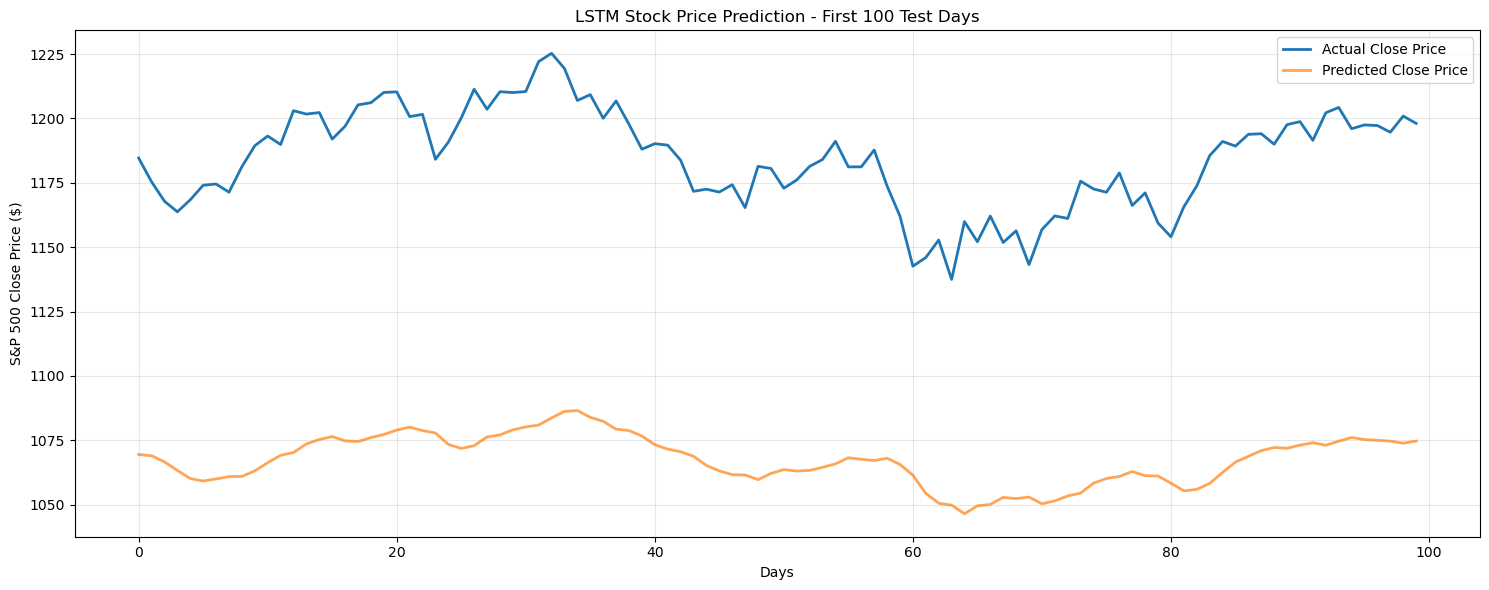

In [11]:
# ============================================
# STEP 6: MAKE PREDICTIONS
# ============================================

model.eval()
with torch.no_grad():
    # Predict on test set
    test_predictions = model(X_test.to(device)).squeeze().cpu().numpy()  # Move to CPU for numpy
    
    # Inverse transform
    test_predictions_actual = scaler.inverse_transform(
        test_predictions.reshape(-1, 1)
    ).flatten()
    
    y_test_actual = scaler.inverse_transform(
        y_test.cpu().numpy().reshape(-1, 1)  # Move to CPU
    ).flatten()

print("\n" + "="*70)
print("PREDICTIONS vs ACTUAL (S&P 500 Close Prices)")
print("="*70)
print(f"{'Day':>5} | {'Actual Close':>15} | {'Predicted Close':>15} | {'Error':>10} | {'Error %':>10}")
print("-" * 70)

for i in range(10):
    actual = y_test_actual[i]
    pred = test_predictions_actual[i]
    error = abs(actual - pred)
    error_pct = (error / actual) * 100
    print(f"{i+1:5} | {actual:15.2f} | {pred:15.2f} | {error:10.2f} | {error_pct:9.2f}%")

# Calculate metrics
mae = np.mean(np.abs(y_test_actual - test_predictions_actual))
mse = np.mean((y_test_actual - test_predictions_actual) ** 2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - test_predictions_actual) / y_test_actual)) * 100

print("\n" + "="*70)
print("MODEL PERFORMANCE METRICS")
print("="*70)
print(f"Mean Absolute Error (MAE):        ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE):   ${rmse:.2f}")
print(f"Mean Absolute Percentage Error:    {mape:.2f}%")

# ============================================
# STEP 7: VISUALIZE PREDICTIONS
# ============================================

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test_actual[:100], label='Actual Close Price', linewidth=2)
plt.plot(test_predictions_actual[:100], label='Predicted Close Price', linewidth=2, alpha=0.7)
plt.xlabel('Days')
plt.ylabel('S&P 500 Close Price ($)')
plt.title('LSTM Stock Price Prediction - First 100 Test Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()